In [4]:
import pandas as pd
from rdkit import Chem
import numpy as np

from pathlib import Path as pt

In [39]:
from xgboost import XGBRegressor, __version__ as xgboost_version
print(xgboost_version)

2.0.3


In [15]:
from time import perf_counter
from typing import Dict, Union, TypedDict
from joblib import parallel_backend

import numpy as np
from pathlib import Path as pt
from datetime import datetime

# for processing
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
import pandas as pd
from sklearn import metrics, __version__ as sklearn_version

print(f"Using scikit-learn version {sklearn_version}")

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    HalvingGridSearchCV,
    HalvingRandomSearchCV,
)
from sklearn.preprocessing import StandardScaler

from dask_ml.model_selection import (
    GridSearchCV as DaskGridSearchCV,
    RandomizedSearchCV as DaskRandomizedSearchCV,
)

# for saving models
from joblib import dump
from sklearn.utils import resample

from dask.diagnostics import ProgressBar

import json
from scipy.optimize import curve_fit

Using scikit-learn version 1.5.1


In [63]:
import matplotlib.pyplot as plt

In [70]:
def linear(x, m, c):
    return m * x + c

In [5]:
loc = pt('/Users/aravindhnivas/Documents/code-testing/ML properties/')
mp_csv_file = loc / 'melting_points_updated.csv'
mp_csv_file.exists()

True

In [6]:
df = pd.read_csv(mp_csv_file, index_col=0)
df

,SMILES,Melting point (C),MP (processed)
0,COP(=S)(OC)OC1=CC=C(C=C1)SC2=CC=C(C=C2)OP(=S)(...,31.6(5),31.60
1,CC(C)C1=CC2=CCC3C(C2CC1)(CCCC3(C)C(=O)O)C,173.5,173.50
2,CC1=CC(=O)CC(C1(C=CC(=CC(=O)O)C)O)(C)C,160,160.00
3,COC1=CC=C(C=C1)C2=CC(=O)C3=C(C=C(C=C3O2)O)O,263,263.00
4,CCCC(=O)NC1=CC(=C(C=C1)OCC(CNC(C)C)O)C(=O)C,121,121.00
...,...,...,...
7976,CCCCN(CCCC)C(=S)[S-].CCCCN(CCCC)C(=S)[S-].[Zn+2],138,138.00
7977,C[CH2-].C[CH2-].[Zn+2],-33.34(2),-33.34
7979,CC(=CC(=O)C)O.CC(=CC(=O)C)O.[Zn],127.3(2),127.30
7980,CN(C)C(=S)[S-].CN(C)C(=S)[S-].[Zn+2],250,250.00


In [7]:
embedding_file = loc / 'melting_points_updated_SMILES_VICGAE_embeddings.npy'
embedding_file.exists()

True

In [103]:
X = np.load(embedding_file, allow_pickle=True)
X.shape

(7437, 32)

In [104]:
y = df['MP (processed)'].values
y.shape

(7437,)

In [105]:
invalid_indices = [i for i, arr in enumerate(X) if np.any(arr == 0)]
valid_mask = np.ones(len(X), dtype=bool)  # Initially, mark all as valid
valid_mask[invalid_indices] = False  # Mark invalid indices as False
X = X[valid_mask]  # Keep only the rows that are marked as True in the valid_mask
y = y[valid_mask]  # Keep only the rows that are marked as True in the valid_mask
X.shape, y.shape

((7123, 32), (7123,))

In [106]:
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=float(test_size))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5698, 32), (1425, 32), (5698,), (1425,))

In [109]:
def main(model, CV=False):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    r2 = metrics.r2_score(y_test_original, y_pred)
    mse = metrics.mean_squared_error(y_test_original, y_pred)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(y_test_original, y_pred)

    # print(f"R2: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    pop, _ = curve_fit(linear, y_test_original, y_pred)
    y_linear_fit = linear(y_test_original, *pop)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(y_test_original, y_pred, 'o', label='XGBoost')
    ax.plot(y_test_original, y_linear_fit, label='Linear fit')
    ax.set_xlabel('True MP (°C)')
    ax.set_ylabel('Predicted MP (°C)')
    ax.legend()
    ax.title.set_text(f"XGBoost: R$^2$ = {r2:.2f}, MSE = {mse:.2f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")
    
    if CV:
        cv_scores = cross_val_score(model, X, y, cv=10, scoring="r2")
        print(f"Mean CV R2 score: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")
    
    return model

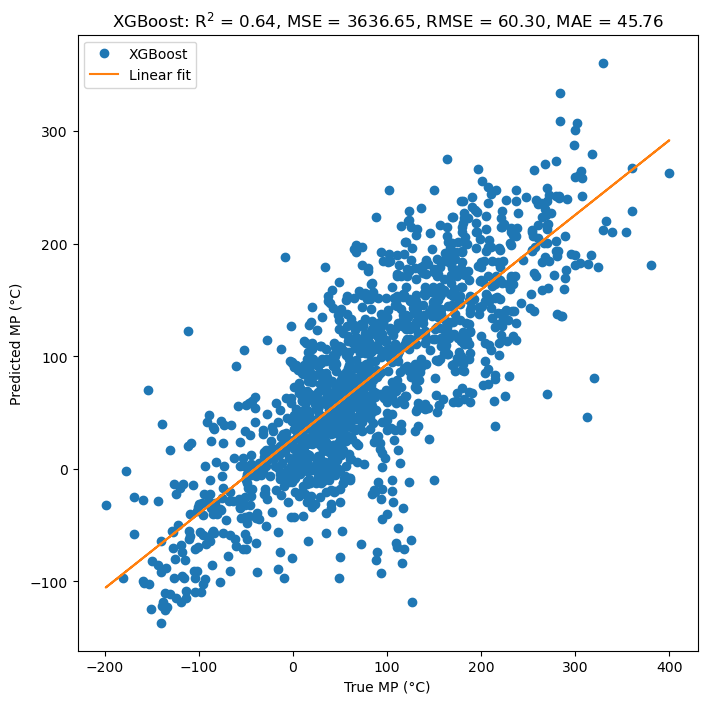

In [110]:
xgb_model = XGBRegressor(n_jobs=-1, verbosity=1)
xgb_model_fitted = main(xgb_model)

In [115]:
xgb_model.__class__.__name__

'XGBRegressor'

In [136]:
# grid search
xgb_model = XGBRegressor(
    n_jobs=-1, verbosity=1,
    # objective='reg:squarederror',
    # early_stopping_rounds=10,
    # eval_metric='rmse',
    # tree_method='gpu_hist',  # GPU acceleration
    # gpu_id=0
)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 1],
    'reg_lambda': [0, 1]
}
# grid_search = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1, verbose=2)
# grid_search = RandomizedSearchCV(
grid_search = HalvingRandomSearchCV(
    xgb_model, param_grid, cv=5, n_jobs=-1, 
    # verbose=1, 
    # n_iter=100,  # number of parameter settings that are sampled
)

# Ensure X_train and y_train are correctly formatted
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


# Check for NaN values
print(f"X_train contains NaN: {np.isnan(X_train).any()}")
print(f"y_train contains NaN: {np.isnan(y_train).any()}")

try:
    grid_search.fit(X_train, y_train)
except ValueError as e:
    print(f"ValueError: {e}")

# grid_results = pd.DataFrame(grid_search.cv_results_)
# grid_results = grid_results.sort_values(by='rank_test_score')
# grid_results.to_csv(loc / f'grid_search_results_{xgb_model.__class__.__name__}.csv', index=False)

# Access the best estimator if fit is successful
if grid_search.best_estimator_:
    best_model = grid_search.best_estimator_
    _ = main(best_model)

X_train shape: (5698, 32)
y_train shape: (5698,)
X_train contains NaN: False
y_train contains NaN: False
ValueError: 
All the 2845 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aravindhnivas/anaconda3/envs/umdapy/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aravindhnivas/anaconda3/envs/umdapy/lib/python3.9/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/Users/aravindhnivas/anaconda3/envs/umdapy/lib/python3.9/site-packages/xgboost/sklearn.py", line 1090, in fit
    self._Booster = train(
  File "/Users/aravindhnivas/anaconda3/envs/umdapy/l

AttributeError: 'HalvingRandomSearchCV' object has no attribute 'best_estimator_'

In [131]:
grid_search.best_params_, grid_search.best_score_

({'subsample': 0.6,
  'reg_lambda': 0,
  'reg_alpha': 1,
  'n_estimators': 500,
  'min_child_weight': 1,
  'max_depth': 8,
  'learning_rate': 0.01,
  'gamma': 0.2,
  'colsample_bytree': 0.7},
 0.5980051676848489)

In [130]:
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results = grid_results.sort_values(by='rank_test_score')
grid_results.to_csv(loc / f'grid_search_results_{xgb_model.__class__.__name__}.csv', index=False)